In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import time
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from numpy.random import default_rng

from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from Corrfunc.theory import DD
from Corrfunc.theory import xi
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_rp_pi_counts_to_wp

In [3]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

# Functions

In [4]:
def compute_xi(r_edges, x, y, z, x_rand, y_rand, z_rand,
               return_full_results=False):
    
    nthreads = 4
    
    start = time.time()
    autocorr=1
    res_dd = DD(autocorr, nthreads, r_edges, x, y, z, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr=0
    res_dr = DD(autocorr, nthreads, r_edges, x, y, z,
                X2=x_rand, Y2=y_rand, Z2=z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')

    start = time.time()
    autocorr=1
    res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    print()
    
    N = len(x)
    N_rand = len(x_rand)
    xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                     res_dd, res_dr,
                                     res_dr, res_rr)
    
    if return_full_results:
        return xi, res_dd, res_dr, res_rr
    
    return xi

In [13]:
def pure_cut(table):
    
    idx_pure = np.where( (table['gaia_crf_source']==True) |
                         ((table['host_galaxy_flag']>0) & (table['host_galaxy_flag']<6)) |
                         (table['classlabel_dsc_joint']=='quasar') |
                         (table['vari_best_class_name']=='AGN') )[0]
    return idx_pure

In [5]:
def radec_to_cartesian(r, ra, dec):
    
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180

    x, y, z = spherical_to_cartesian(r, theta, phi)
    return np.array([x, y, z])

In [6]:
def spherical_to_cartesian(r, theta, phi):
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])

In [7]:
def generate_shuffled_random(factor, data, rng, redshift_name='redshift_qsoc'):
    N = len(data)
    N_rand = factor*N

    i_vals = np.arange(N)

    i_radec_rand = rng.choice(i_vals, size=N_rand, replace=True)
    ra_rand = data['ra'][i_radec_rand]
    dec_rand = data['dec'][i_radec_rand]

    i_redshift_rand = rng.choice(i_vals, size=N_rand, replace=True)
    redshift_rand = data[redshift_name][i_redshift_rand]
    dist_rand = data['distance'][i_redshift_rand]
    
    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    return rand

In [23]:
def add_xyz(data, cosmo, redshift_name):
    dist_photoz = (cosmo.comoving_distance(data[redshift_name])*cosmo.h).value # convert to Mpc/h
    data.add_column(dist_photoz, name='distance')

    x, y, z = radec_to_cartesian(data['distance'], data['ra'], data['dec'])
    data.add_column(x, name='x')
    data.add_column(y, name='y')
    data.add_column(z, name='z')

## Data

In [10]:
fn_photoz = '../data/gaia_photoz.fits'
data_photoz = Table.read(fn_photoz, format='fits')
print(len(data_photoz))

981927


In [16]:
fn_all = '../data/gaia_wise_panstarrs_tmass.fits.gz'
data_all = Table.read(fn_all, format='fits')
print(len(data_all))

6649162


In [27]:
idx_pure = pure_cut(data_all)
data = data_all[idx_pure]
print(len(data))

1942825


In [28]:
rng = default_rng(seed=42)

### Convert to cartesian

In [18]:
cosmo = astropy.cosmology.Planck15

In [20]:
add_xyz(data_photoz, cosmo, 'redshift_photoz_est')

In [29]:
add_xyz(data, cosmo, 'redshift_qsoc')

redshift_qsoc
-------------
          nan
          nan
          nan
          nan
          nan
          nan
          nan
          nan
          nan
          nan
          ...
     1.326606
   0.78890383
    4.3965154
    2.5417588
          nan
          nan
          nan
          nan
    2.4830084
          nan
Length = 1942825 rows


# Cut full 

### Cut out magellanic clouds

In [30]:
# the example from astropy is the magellanic clouds:
# https://docs.astropy.org/en/stable/coordinates/matchsep.html
coord_lmc = SkyCoord('5h23m34.5s', '-69d45m22s', frame='icrs')
coord_smc = SkyCoord('0h52m44.8s', '-72d49m43s', frame='icrs')

In [31]:
coords = SkyCoord(data['ra'], data['dec'], frame='icrs')

separations_lmc = coord_lmc.separation(coords).to(u.deg)
sep_max_lmc = 6*u.deg

separations_smc = coord_smc.separation(coords).to(u.deg)
sep_max_smc = 3*u.deg

idx_nomc = np.where((separations_lmc > sep_max_lmc ) &
                    (separations_smc > sep_max_smc ))[0]
print(len(data['ra']), len(idx_nomc), idx_nomc.max())

1942825 1913824 1942824


In [32]:
redshift_min = 0.5
redshift_max = 2.5
g_thresh = 20.2

In [33]:
idx_zslice_nomc = np.where((data['redshift_qsoc'] > redshift_min) & 
                      (data['redshift_qsoc'] < redshift_max) &
                      (data['phot_g_mean_mag'] < g_thresh) &
                      (separations_lmc > sep_max_lmc ) &
                      (separations_smc > sep_max_smc ))[0]
len(idx_zslice_nomc)
data_zslice_nomc = data[idx_zslice_nomc]

Text(0, 0.5, 'dec (deg)')

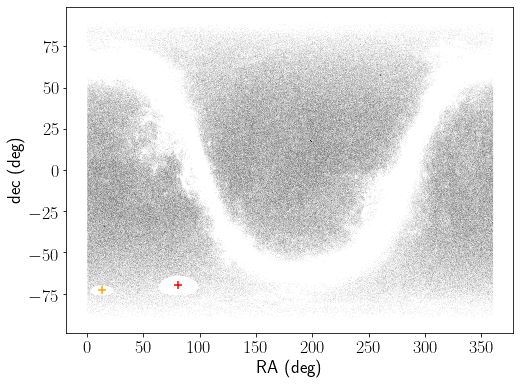

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(data_zslice_nomc['ra'], data_zslice_nomc['dec'], s=0.01, alpha=0.1, c='k')
plt.scatter(coord_lmc.ra.to(u.deg), coord_lmc.dec.to(u.deg), s=50, c='r', marker='+')
plt.scatter(coord_smc.ra.to(u.deg), coord_smc.dec.to(u.deg), s=50, c='orange', marker='+')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [42]:
idx_photoz_zslice = np.where((data_photoz['redshift_photoz_est'] > redshift_min) & 
                      (data_photoz['redshift_photoz_est'] < redshift_max) &
                      (data_photoz['phot_g_mean_mag'] < g_thresh))[0]
len(idx_photoz_zslice)
data_photoz_zslice = data_photoz[idx_photoz_zslice]

## Randoms

In [58]:
factor = 10
rand_photoz = generate_shuffled_random(factor, data_photoz_zslice, rng, redshift_name='redshift_photoz_est')

In [59]:
factor = 10
rand = generate_shuffled_random(factor, data_zslice_nomc, rng, redshift_name='redshift_qsoc')

# CFs

In [60]:
nthreads = 4
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [61]:
xi_photoz_zslice = compute_xi(r_edges, 
                      data_photoz_zslice['x'], data_photoz_zslice['y'], data_photoz_zslice['z'], 
                      rand_photoz['x'], rand_photoz['y'], rand_photoz['z'])

Time: 0.2543 s
Time: 3.1126 s
Time: 15.7723 s



In [62]:
xi_zslice_nomc = compute_xi(r_edges, 
                      data_zslice_nomc['x'], data_zslice_nomc['y'], data_zslice_nomc['z'], 
                      rand['x'], rand['y'], rand['z'])

Time: 0.3603 s
Time: 4.9177 s
Time: 21.7725 s



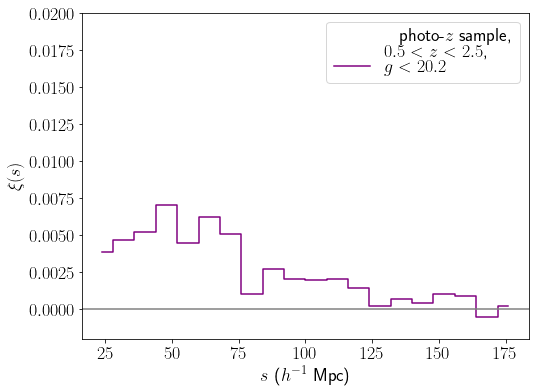

In [79]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_photoz_zslice, where='mid', color='purple',
         label=r'photo-$z$ sample,\\$0.5<z<2.5$,\\$g<20.2$')


plt.xlabel(r'$s$ ($h^{-1}$ Mpc)')
plt.ylabel(r'$\xi(s)$')
plt.axhline(0, color='grey')
plt.ylim(-0.002, 0.02)
plt.legend()

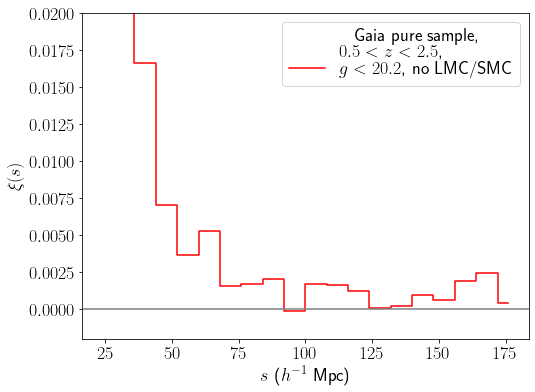

In [80]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_zslice_nomc, where='mid', color='red', 
         label=r'Gaia pure sample,\\$0.5<z<2.5$,\\$g<20.2$, no LMC/SMC')

plt.xlabel(r'$s$ ($h^{-1}$ Mpc)')
plt.ylabel(r'$\xi(s)$')
plt.axhline(0, color='grey')
plt.ylim(-0.002, 0.02)
plt.legend()

# finger plot

In [84]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 

c1 = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
c2 = SkyCoord(ra=data_photoz['ra'], dec=data_photoz['dec'], frame='icrs') 
x1 = c2.search_around_sky(c1, 1*u.arcsec) # Hogg thinks this is idiotic

max(x1[0]), max(x1[1])

tab = data_photoz[x1[1]]
tab_sdss = tab_sdss[x1[0]]
len(tab), len(tab_sdss)

(306354, 306354)

In [82]:
tab_sdss['Z'].shape

(750414,)

In [85]:
np.array(tab['redshift_qsoc'])

array([0.8445841, 2.0385754, 1.9943572, ..., 1.744547 , 2.204289 ,
       1.4635392], dtype=float32)